In [1]:
!pip install gower

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# 한글 폰트 설정을 위한 코드 (이미 설정하셨다면 생략)
plt.rc('font', family='Malgun Gothic') # Windows
# plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [3]:
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# 데이터 준비

In [52]:
df = pd.read_csv('C:/Users/sopi0/codes/korea-tour-recommender/data/2024_7차_전처리.csv')
df.head()

,아이디,성별,연령별,한국 방문횟수(카테고리),문1-1. 한국여행 관심 계기_1,문3-2. 고려한 관광인프라_1,여행동반자_그룹,방문 지역 수,여행 패턴,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측,문3-1. 고려한 관광활동_1순위
0,57,2,5,4,콘텐츠 및 문화,안전 및 퀄리티,가족형,1,서울 심층형,451.666667,6.0,도시 소비형
1,58,2,4,4,콘텐츠 및 문화,여행 편의성,가족형,1,서울 단기형,272.935000,5.0,경험형
2,59,2,3,3,콘텐츠 및 문화,여행 편의성,단체형,1,서울 심층형,177.650000,6.0,특수 목적
3,60,1,2,1,콘텐츠 및 문화,여행 편의성,혼자형,1,서울 심층형,153.780000,6.0,경험형
4,61,2,2,4,경험형,가성비,가족형,2,서울 단기형,329.460000,5.0,도시 소비형


In [33]:
# '여행 패턴'과 '총 체재기간'의 상관성이 높게 니옴
df.drop(columns='여행 패턴', inplace=True)

In [34]:
df.head()

,아이디,성별,연령별,한국 방문횟수(카테고리),문1-1. 한국여행 관심 계기_1,문3-2. 고려한 관광인프라_1,여행동반자_그룹,방문 지역 수,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측,문3-1. 고려한 관광활동_1순위
0,57,2,5,4,콘텐츠 및 문화,안전 및 퀄리티,가족형,1,451.666667,6.0,도시 소비형
1,58,2,4,4,콘텐츠 및 문화,여행 편의성,가족형,1,272.935000,5.0,경험형
2,59,2,3,3,콘텐츠 및 문화,여행 편의성,단체형,1,177.650000,6.0,특수 목적
3,60,1,2,1,콘텐츠 및 문화,여행 편의성,혼자형,1,153.780000,6.0,경험형
4,61,2,2,4,경험형,가성비,가족형,2,329.460000,5.0,도시 소비형


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10131 entries, 0 to 10130
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   아이디                                    10131 non-null  int64  
 1   성별                                     10131 non-null  int64  
 2   연령별                                    10131 non-null  int64  
 3   한국 방문횟수(카테고리)                          10131 non-null  int64  
 4   문1-1. 한국여행 관심 계기_1                     10131 non-null  object 
 5   문3-2. 고려한 관광인프라_1                      10131 non-null  object 
 6   여행동반자_그룹                               10131 non-null  object 
 7   방문 지역 수                                10131 non-null  int64  
 8   문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)  10131 non-null  float64
 9   문9-3. 총 체재기간_61일 이상 결측                 10131 non-null  float64
 10  문3-1. 고려한 관광활동_1순위                     10131 non-null  object 
dtypes:

# 1. 데이터 전처리 (Data Preprocessing)

## 데이터 타입 변경(범주형, 수치형)

In [36]:
# 분석에 불필요한 고유 ID 제거
cluster_data = df.drop(columns=['아이디']).copy()

# [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
categorical_cols_int = ['성별']
for col in categorical_cols_int:
    cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

< 분석 대상 변수 타입 확인 >
성별                                        object
연령별                                        int64
한국 방문횟수(카테고리)                              int64
문1-1. 한국여행 관심 계기_1                        object
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문9-3. 총 체재기간_61일 이상 결측                   float64
문3-1. 고려한 관광활동_1순위                        object
dtype: object
--------------------------------------------------


## 수치형 로그변환

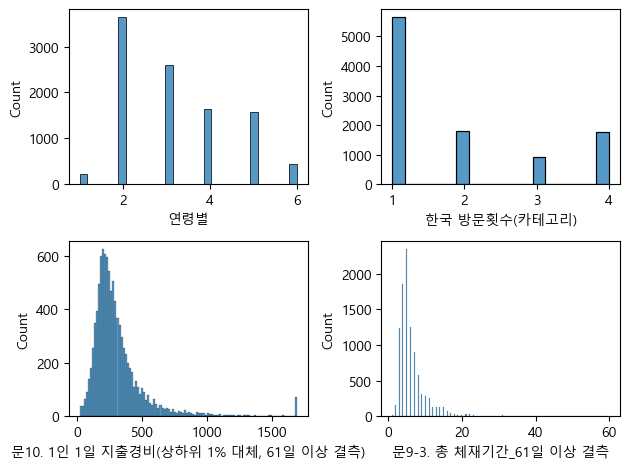

In [40]:
num_cols = ['연령별', '한국 방문횟수(카테고리)', 
            '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '문9-3. 총 체재기간_61일 이상 결측']
fig, ax = plt.subplots(2, 2)
for i in range(4):
    sns.histplot(data=df[num_cols], x = num_cols[i], ax=ax[i//2, i%2])
    
plt.tight_layout()
plt.show()

In [41]:
# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', 
    '문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.


# 2. Gower Distance Matrix 계산

In [42]:
print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10131, 10131)
   -> 메모리 점유율(약): 391.53 MB


# 3. 계층적 군집화 (Hierarchical Clustering)

In [43]:
print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


# 4. 덴드로그램 시각화 및 최적의 k 찾기

c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


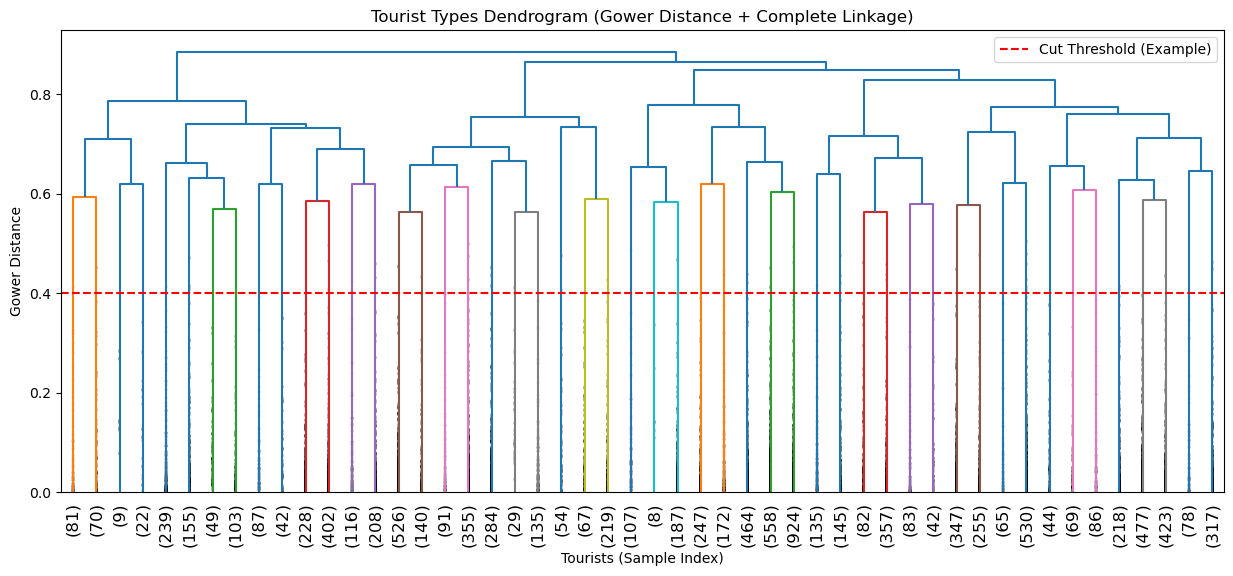

In [26]:
plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

# 5. 최종 군집 할당 및 페르소나 정의

In [ ]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 4

# 군집 라벨 생성
labels = fcluster(Z, k_final, criterion='maxclust')
df['Cluster'] = labels # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    '문9-3. 총 체재기간_61일 이상 결측': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    '성별': get_mode,
    '연령별': get_mode,
    '한국 방문횟수(카테고리)': get_mode,
    '문1-1. 한국여행 관심 계기_1': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = df.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = df['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)


< 군집별 특성 요약 (k=5) >


Cluster,1,2,3,4,5
방문 지역 수,1.518956,1.303403,1.247945,1.571573,1.648302
"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",319.803088,313.915886,372.022211,307.248533,301.000157
문9-3. 총 체재기간_61일 이상 결측,6.973387,5.362004,5.113699,7.024279,7.452075
성별,2,2,2,1,1
연령별,2,2,2,2,2
한국 방문횟수(카테고리),1,1,4,1,1
문1-1. 한국여행 관심 계기_1,경험형,가성비 및 접근성,가성비 및 접근성,경험형,경험형
문3-2. 고려한 관광인프라_1,여행 편의성,여행 편의성,안전 및 퀄리티,여행 편의성,여행 편의성
여행동반자_그룹,친구형,가족형,가족형,가족형,가족형
문3-1. 고려한 관광활동_1순위,"역사, 전통, 자연",도시 소비형,도시 소비형,도시 소비형,"역사, 전통, 자연"
